Authors: Altan Nagji, Amritha Iyer, Samantha Liu, Samuel Ziegelbein

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import pickle
%matplotlib inline

# Introduction

Our goal is to better understand people's attitudes towards Facebook, and how those attitudes, combined with demographic information, affect Facebook usage. Social media has come to play such an important role in how people communicate with each other and receive information, and Facebook is one of the most prominent social media platforms. In particular, a better understanding of what reasons people have for using Facebook along with what dissuades people from using it can provide Facebook (the company) with useful insights regarding what users and non-users alike consider to be important. Is it entertainment, connection with friends, convenience of information, or something else entirely that drives people's use of the site? Similarly, is it concerns over privacy, misinformation, inappropriate content, or something else that steers many away from the site?

Combining these attitudes with demographic information will additionally allow us to get an idea of whether access to and usage of Facebook and similar platforms is equitable. This is also valuable information for social media companies themselves, as the insights could allow them to focus efforts on making their platforms more inclusive for groups with disproportionately low participation.

We've used the dataset titled *Demographically Representative Survey on Facebook Non/Use 2015* which can be found here: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/8GRBRZ/40TTNH&version=3.1. This dataset includes survey participants' responses to a number of questions, notably including questions about their demographics, whether and how often they use Facebook, why and how they access Facebook, experiences they've had using Facebook, who they're friends with on Facebook, and their perceptions of/attitidues about Facebook. We'll focus specifically on the demographic, usage, and attitudes towards Facebook data, with the goal of constructing a model to predict whether an individual uses Facebook based on their demographics and Facebook attitudes.

# Survey Overview

Below is a list of the questions participants were asked during the survey.

In [ ]:
data = pd.read_csv('fbdata.csv')
questions = data.iloc[0, :]
for i, q in enumerate(questions):
  print(i, ":", q)

0 : Start Date
1 : End Date
2 : Progress
3 : Duration (in seconds)
4 : Finished
5 : Recorded Date
6 : Response ID
7 : I consent to take part in this study.
8 : What is your age?
9 : What is your gender? - Selected Choice
10 : What is your gender? - Other - Text
11 : For statistical purposes, last year (that is in 2014), what was your total household income from all sources before taxes?
(please enter only numbers -- no commas, decimals, or dollar symbols)
12 : What is your marital status?
13 : How would you describe yourself?
14 : Which of the following best describes your highest achieved education level?
15 : Please identify your political views on the scale below: - Political Spectrum
16 : Please indicate how well each of the following words describes your experiences with, perceptions of, and attitudes about Facebook. - accurate
17 : Please indicate how well each of the following words describes your experiences with, perceptions of, and attitudes about Facebook. - addicting
18 : P

# Creating the Usage Label and Visualizing the Breakdown by Category

After looking through the set of survey questions, we noticed that the participants could be placed into one of three categories based on their usage of facebook: those who were current FB users, those who had used FB in the past, and those who had never used FB. In addition, we included labels 'terminated' and 'unknown', corresponding to two different classes of survey respondents for whom there was insufficient information to determine their facebook usage; more on those two categories in the data cleaning section below. The proportion of participants in each category was visualized with a pie chart.


In [ ]:
def labelUsage(row):
  if not pd.isna(row['term']):
    return 'terminated'
  elif row['HaveFB'] == 'Yes':
    return 'current'
  elif row['EverHadFB'] == 'Yes':
    return 'past'
  elif row['EverHadFB'] == 'No':
    return 'never'
  else:
    return 'unknown'

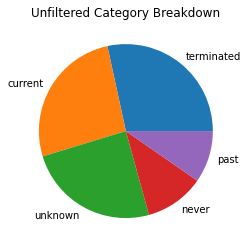

In [ ]:
data['usage'] = data.apply(labelUsage, axis=1)
dataNums = data['usage'].value_counts()
plt.pie(dataNums, labels=dataNums.index)
plt.title('Unfiltered Category Breakdown')
plt.show()

# Filtering Data and General Data Cleaning

There were a number of things we did to make the dataset features more managable and useful, including:

* **Dropping irrelevant features:** We dropped a number of features that didn't seem useful, including survey duration, start time, end time, response ID, and other metadata type features.
* **Dropping free response questions:** A number of survey questions had free-form text fields for responses. Since these questions were too open ended and the answers too varied, we would not be able to find a quantitative encoding for them, and thus these features were dropped.
* **Dropping questions after “Do you currently have Facebook.”:** After this question, the survey form branched, and participants were asked different questions depending on whether they currently had, previously had, or never had Facebook. Since these features were missing for many respondents and could not reasonably be imputed, we just dropped them.
* **Dropping rows with > 2 null values:** We counted the number of null values in each row and found that there were many rows missing one or two values, just a few rows missing 3-10 values, and a fair number of rows missing many values. We determined that the best trade-off between data quality and data quantity was to drop rows with more than 2 null values. Rows with just one or two missing values would be taken care of through imputation, described further later on.

There were also two other types of records in addition to those falling under one of the three main labels of 'current', 'past', or 'never'.
* **Terminated:** These participants were labeled as terminated in the original dataset. There are a number of reasons a record could have been marked as terminated, including if the respondent exited the survey before completing it or completed the survey unreasonably quickly.
* **Unknown:** Upon close inspection and double checking the paper associated with the data, we realized that the survey was programmed to terminate early for certain demographic groups if they had already been sampled sufficiently. For example, after 89 respondents aged 25-34 were collected, subsequent respondents in that age group were excluded. Thus, there were many records with only the demographic data filled out and nothing else, which we have marked as unknown.

Since we lacked sufficient and reliable information for respondents in these two groups, we ultimately decided to drop any records given the 'terminated' or 'unknown' label.

Data Points after Initial Cleaning:  599


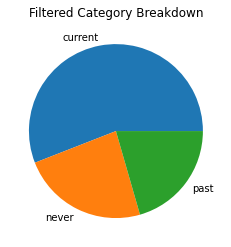

In [ ]:
text_based = [0, 1, 2, 3, 4, 5, 6, 7, 10, 120, 121] + list(range(53,118))
data_no_text = data.drop(data.columns[text_based], axis=1)
filtered_data = data_no_text[(data_no_text['usage'] !='terminated') & (data_no_text['usage']!='unknown')]
filtered_data = filtered_data.drop(['gc', 'SC0'], axis=1)

#Check number of data points remaining after cleaning out terminated and unlabeled data
print("Data Points after Initial Cleaning: ", len(filtered_data))

dataNums = filtered_data['usage'].value_counts()
plt.pie(dataNums, labels=dataNums.index)
plt.title('Filtered Category Breakdown')
plt.show()

# Visualizing Feature Distributions

After a bit more datatype-related cleaning, we decided to plot a histogram/bar chart (as appropriate) of the distribution of each feature to get a better idea of the data we were working with. We also displayed a correlation matrix with all the features.

In [ ]:
#Features such as Age, Income, and "Rating Questions", are Quantitative Responses that are stored as strings, and these values are converted to numeric representations
filtered_data = filtered_data.replace('7 - Very Much', 7)
filtered_data = filtered_data.replace('1 - Not at all', 1)
not_numeric_columns = ['Gender', "Edu", 'PolitViews_1', 'Ethnicity', 'Marital']
for column in filtered_data.columns:
  if column not in not_numeric_columns + ['usage', 'HaveFB']:
    filtered_data[column] = pd.to_numeric(filtered_data[column])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


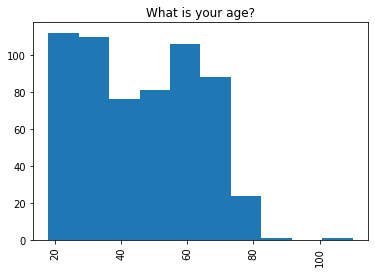

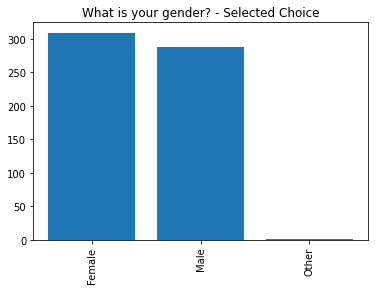

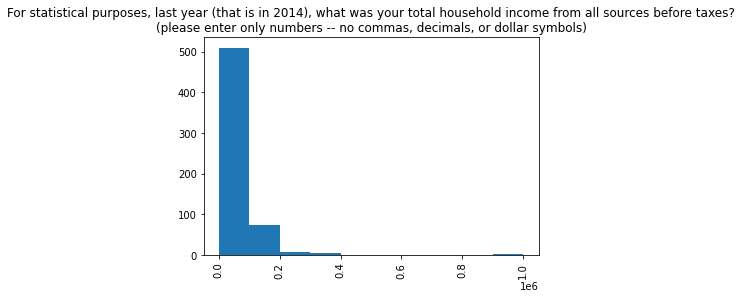

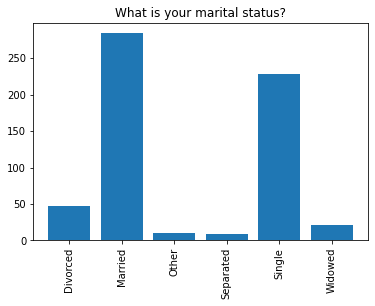

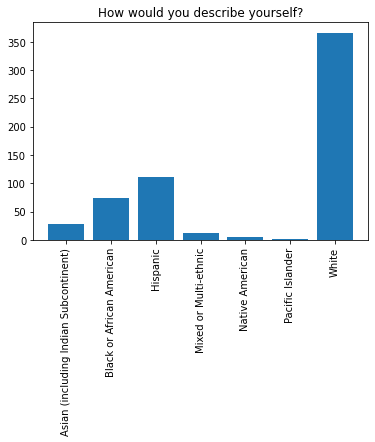

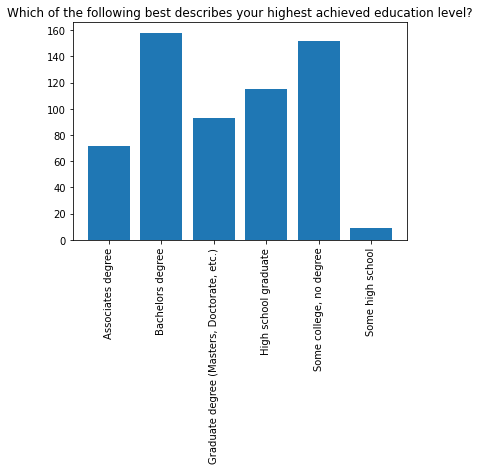

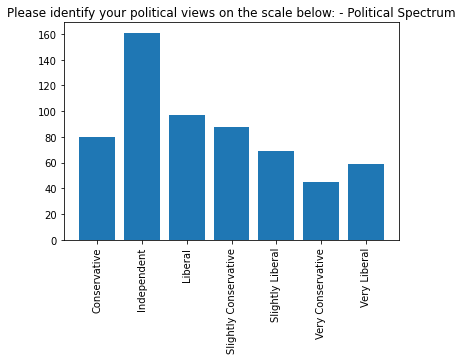

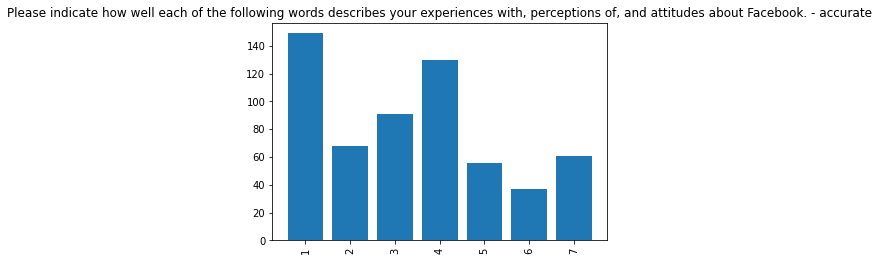

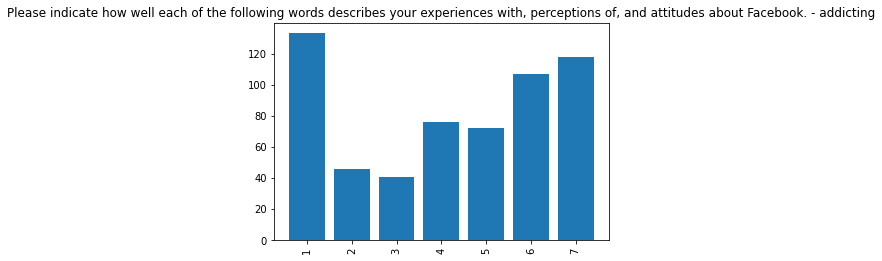

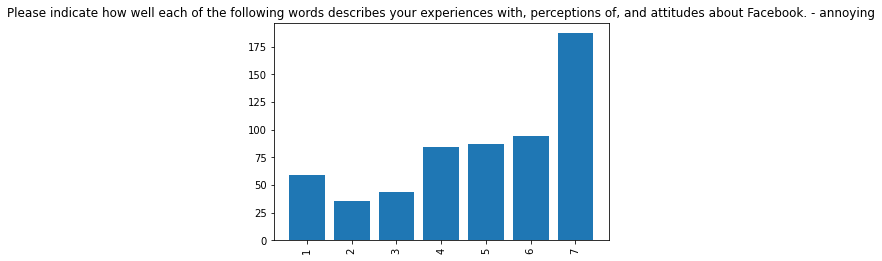

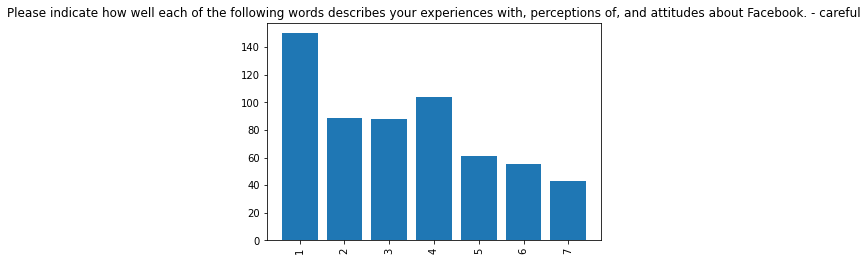

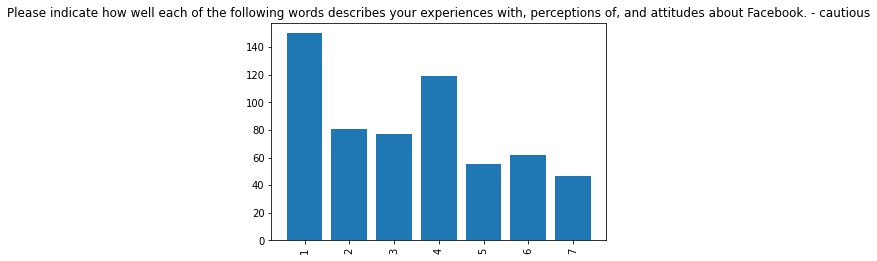

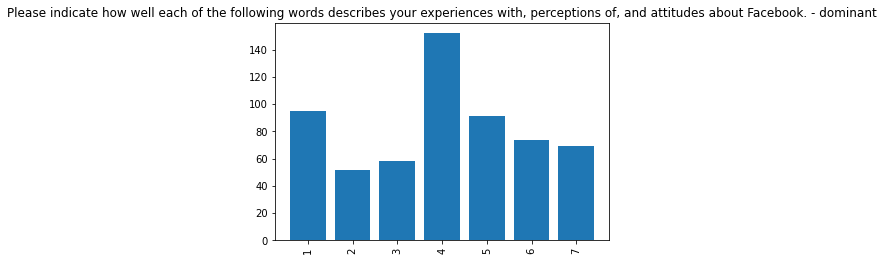

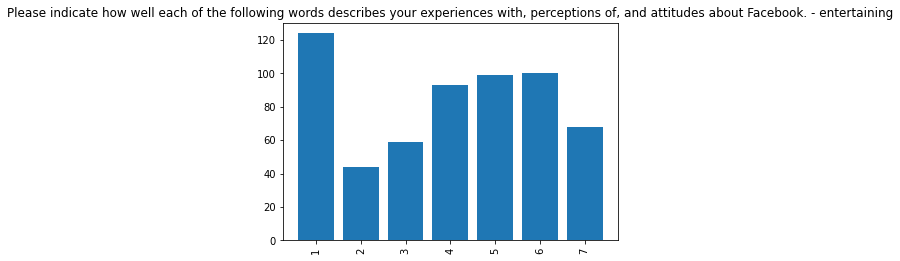

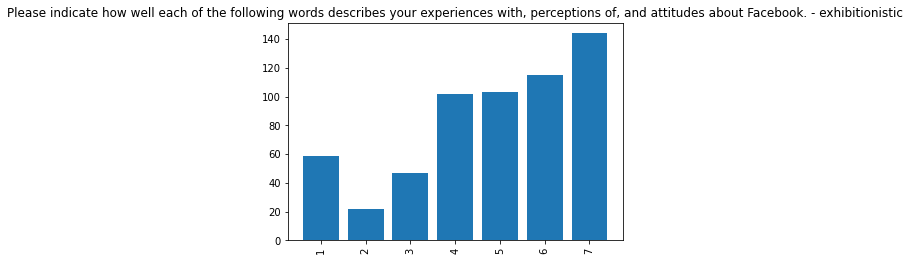

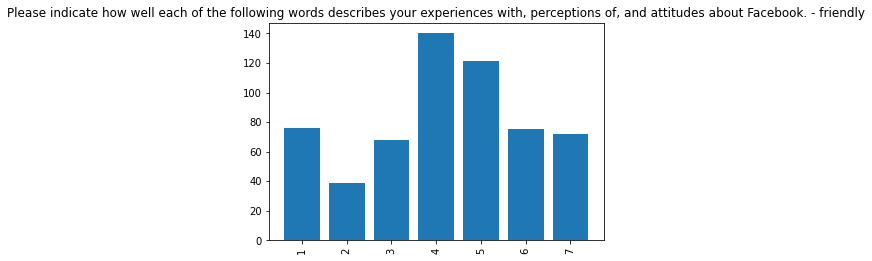

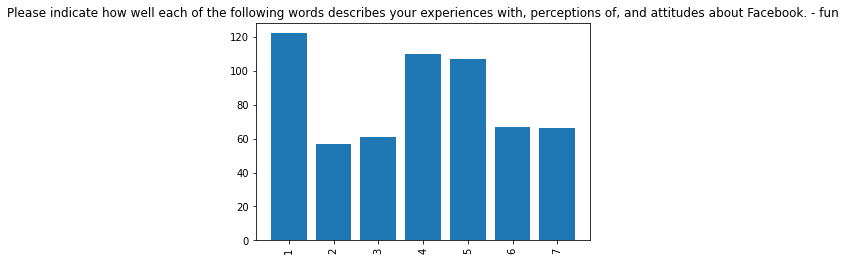

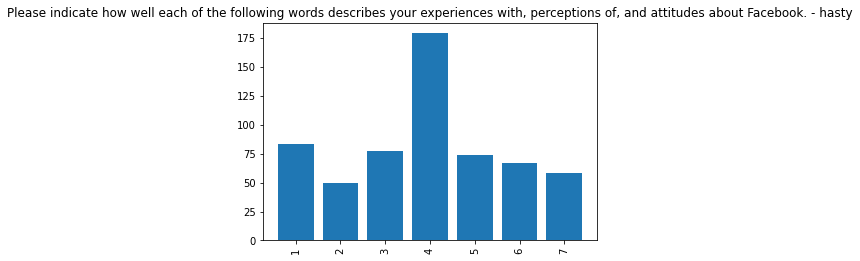

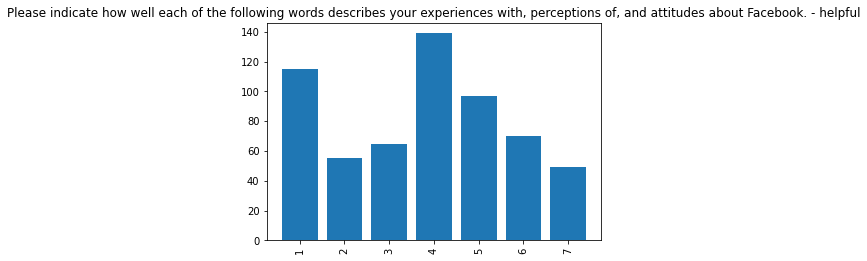

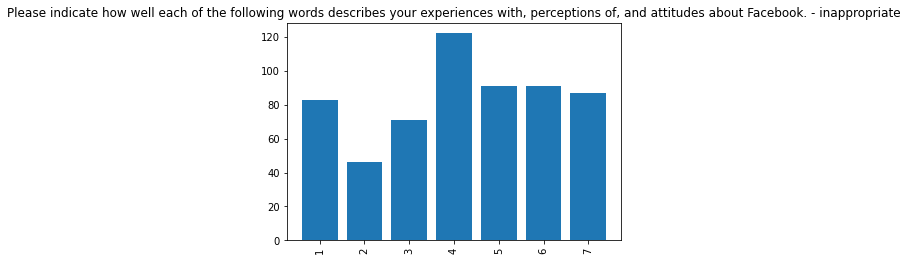

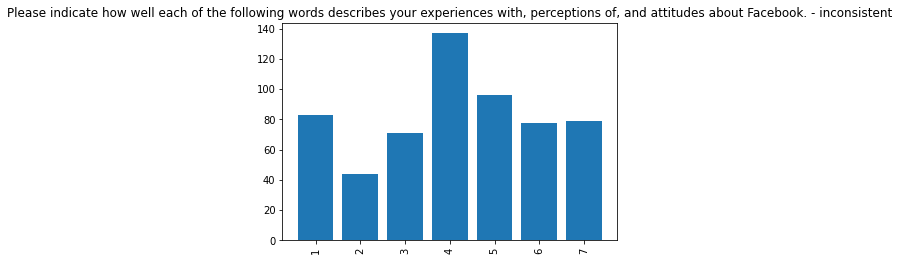

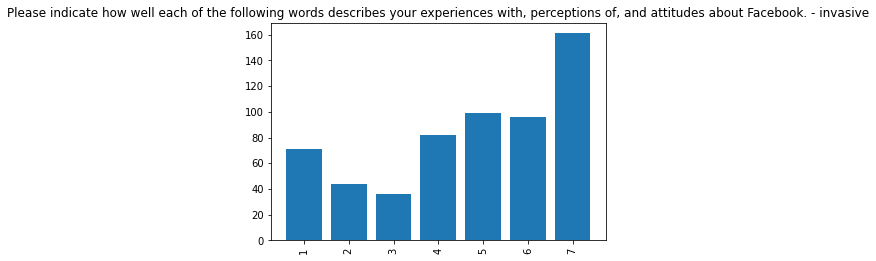

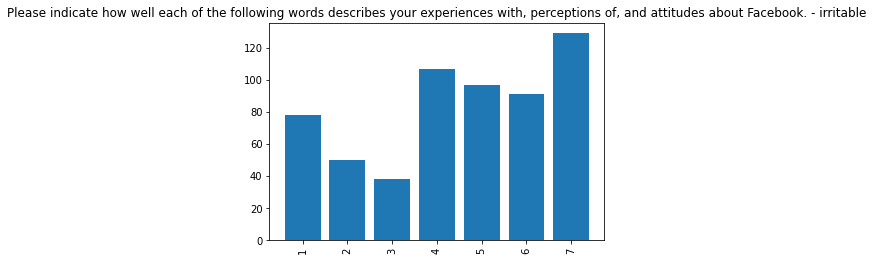

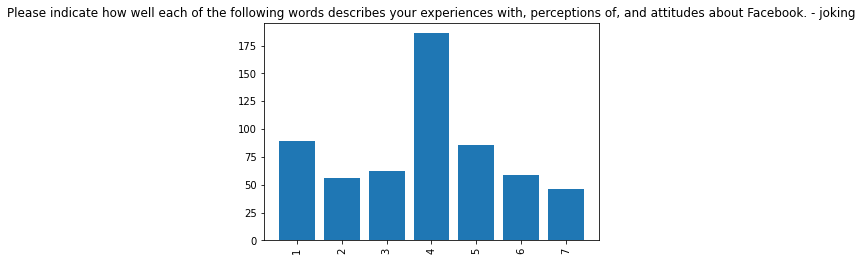

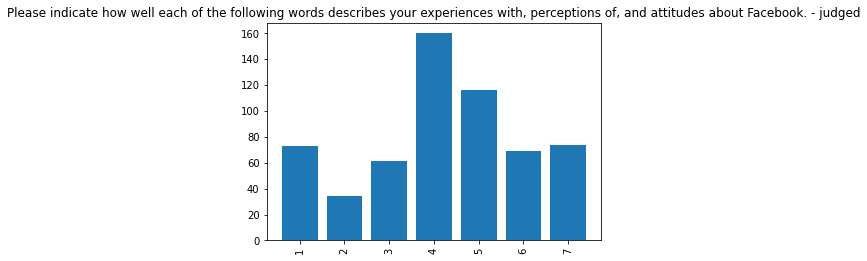

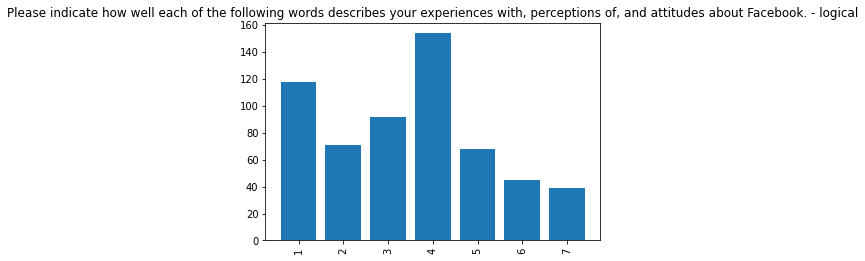

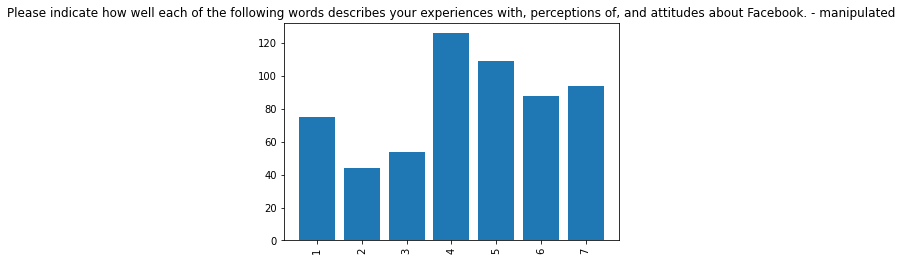

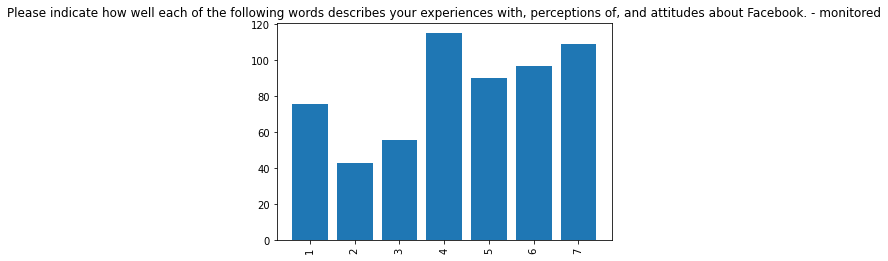

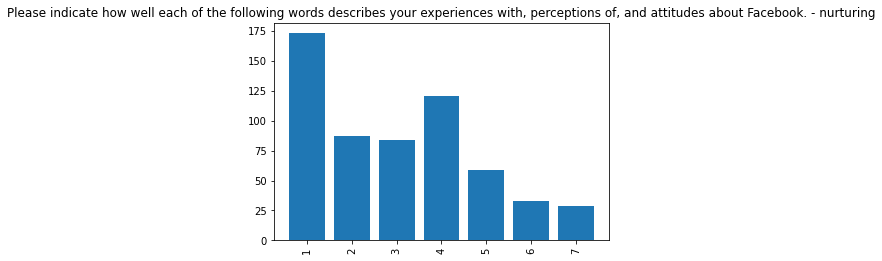

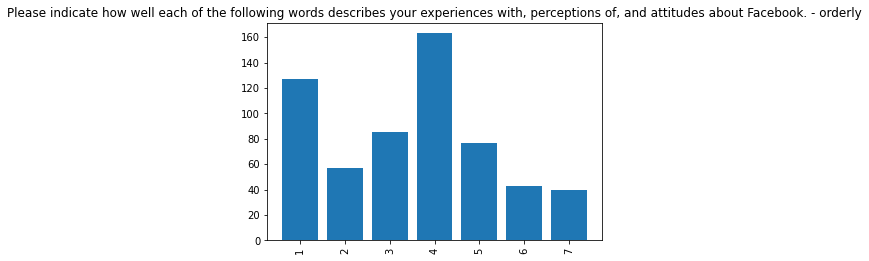

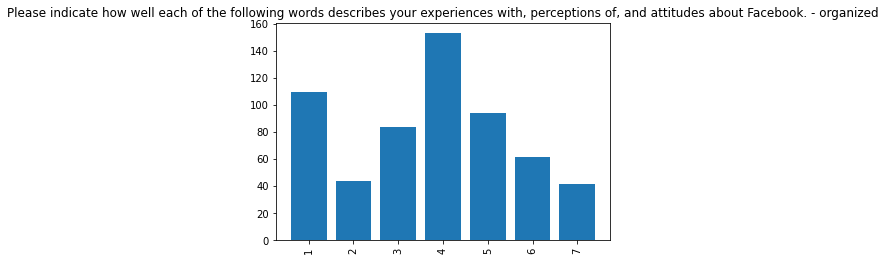

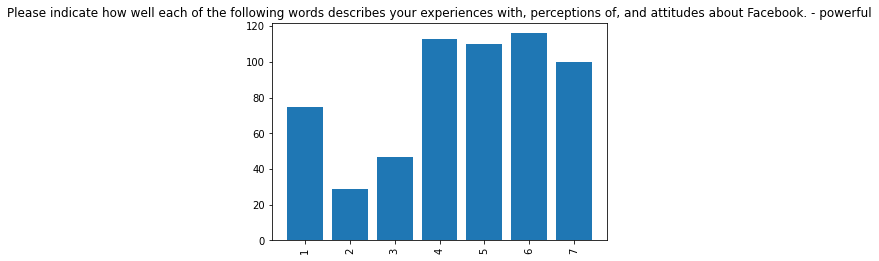

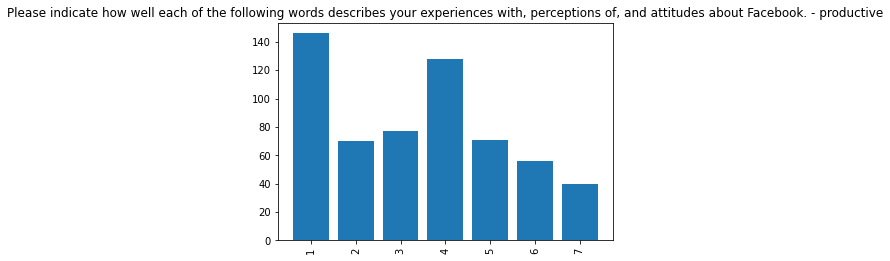

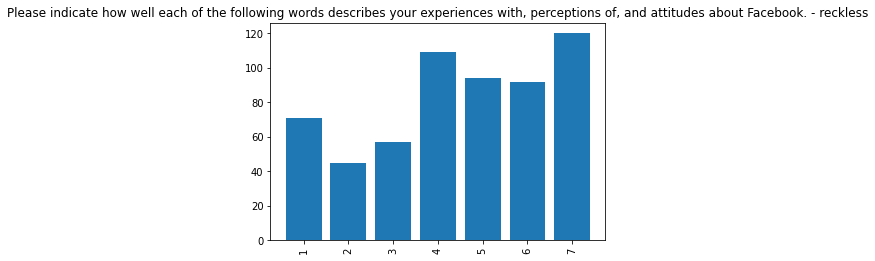

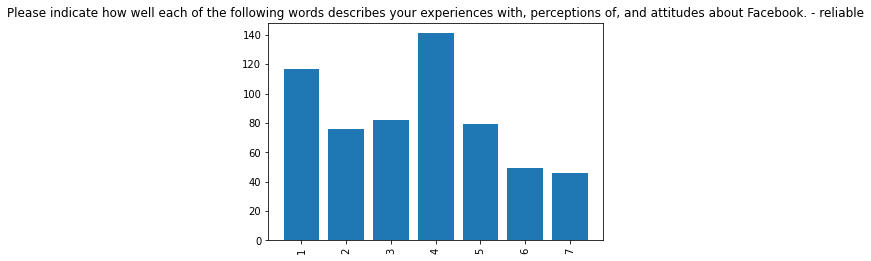

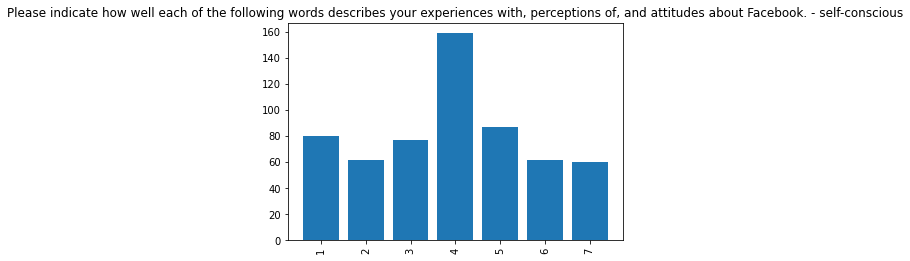

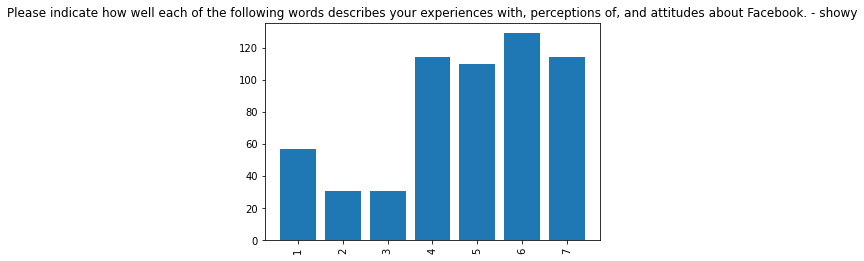

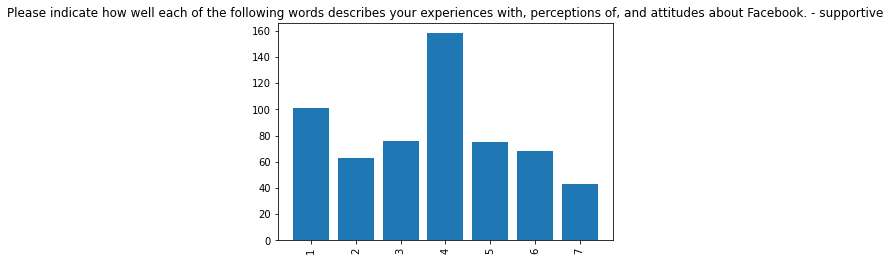

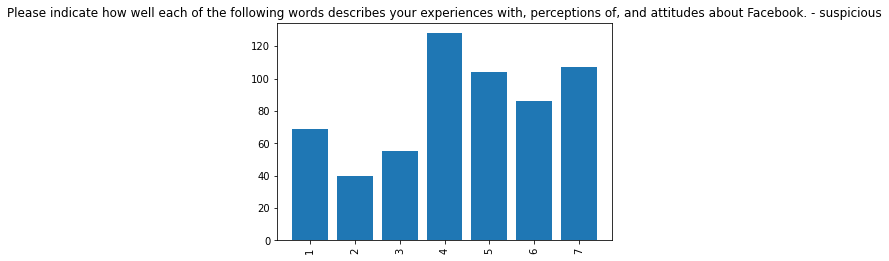

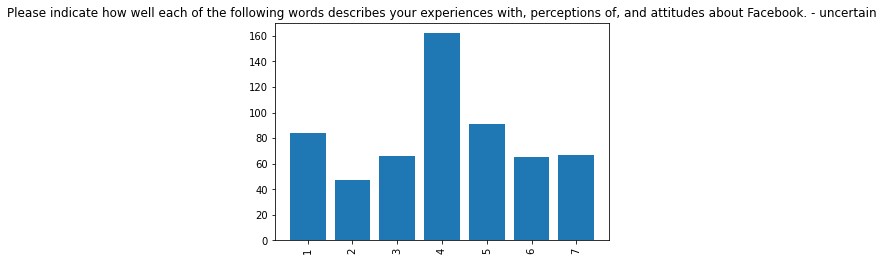

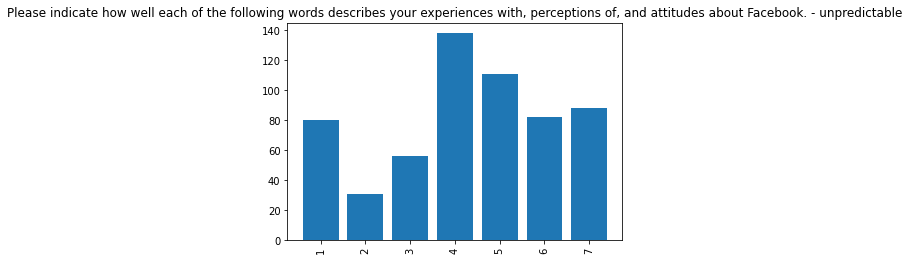

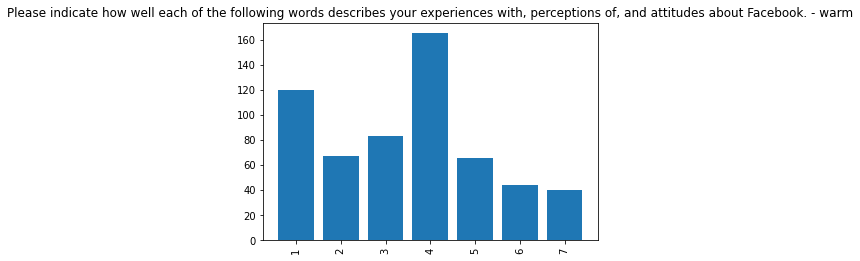

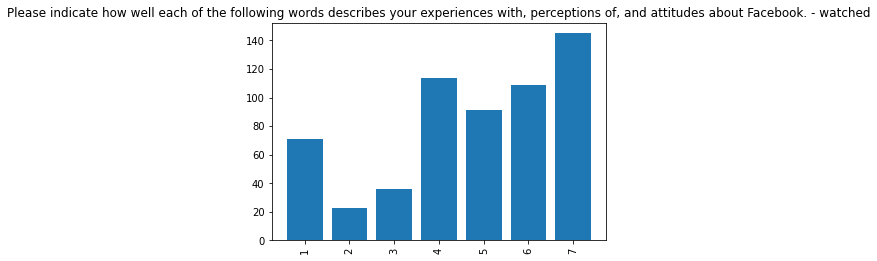

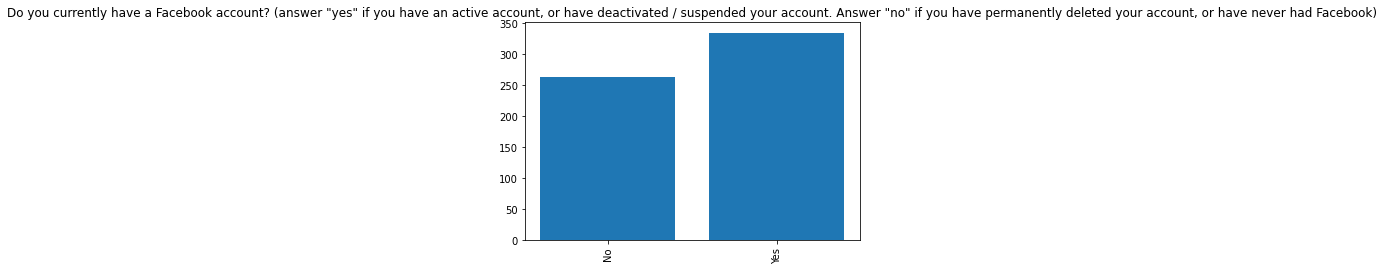

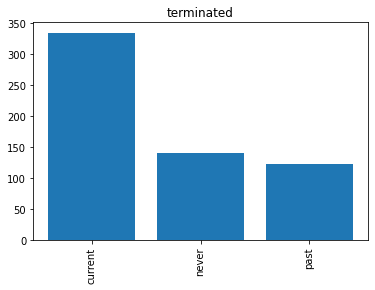

In [ ]:
for col in filtered_data.columns:
  plt.figure()
  if col == 'Age' or col == 'Income':
    plt.title(data[col][0])
    plt.xticks(rotation='vertical')
    plt.hist(filtered_data[col])
  else:
    counts = filtered_data[col].value_counts()
    counts.sort_index(axis=0, inplace=True)
    plt.title(data[col][0])
    plt.xticks(rotation='vertical')
    plt.bar(height=counts, x=counts.index)

The correlation matrix below was used to see if any two features had high univariate correlation. Unfortunately, none of the data seemed to have significant trends that we could use to drive our feature engineering process, but it was wise to check anyways!

<Figure size 7200x7200 with 0 Axes>

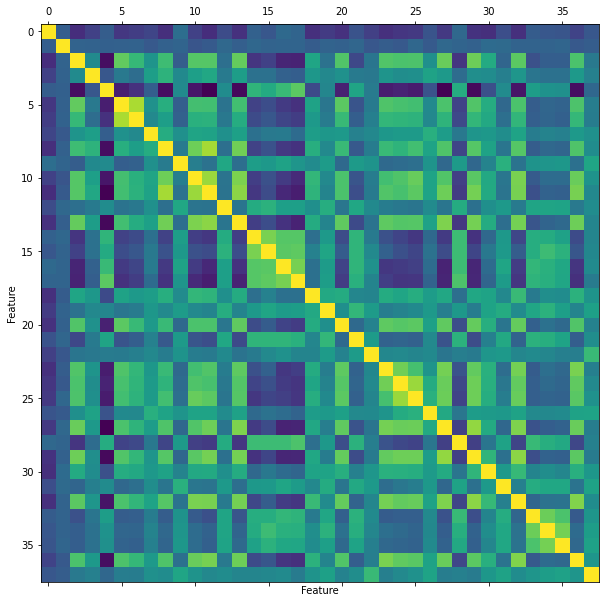

In [ ]:
# correlation matrix
fig = plt.figure()
plt.rcParams["figure.figsize"] = (20, 10)
cm = plt.matshow(filtered_data.corr())
plt.xlabel('Feature')
plt.ylabel('Feature')
fig.set_figheight(100)
fig.set_figwidth(100)
fig.show()

# Categorical Features

A number of important features, including race, marital status, gender, and political views, are categorical, so we one-hot encoded them for compatibility with learning algorithms requiring numeric inputs.

In [ ]:
# one hot encode non-numeric columns
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
ohe =enc.fit_transform(filtered_data[not_numeric_columns])
ohe = ohe.toarray()

#get one hotted column names (new column name = original feature name + value name)
#e.g. "Gender" becomes "GenderMale" and "GenderFemale"
newcols = np.array([])
for idx, ar in enumerate(enc.categories_):
  oldcol = not_numeric_columns[idx]
  ar = [oldcol + str(i) for i in ar]
  newcols = np.concatenate([newcols, ar])
onehottedframe = pd.DataFrame(data=ohe, columns=newcols, index=filtered_data.index)
final_dataset = pd.concat((filtered_data, onehottedframe), axis=1)

In [ ]:
#Drop the not numeric columns that we one hotted in the previous cell!
final_dataset = final_dataset.drop(not_numeric_columns, axis=1)

#Create our labels and features
labels = final_dataset['usage']
features = final_dataset.drop(['usage', 'HaveFB'], axis=1)
binary_labels = final_dataset['HaveFB']
binary_features = final_dataset.drop(['usage', 'HaveFB'], axis=1)

# Main Classification Algorithms Setup

We tried three different model types for classification: random forest, k-nearest neighbors, and a neural network. For each of these, we made use of the following pipeline:

* First, we impute null values using sklearn.impute.SimpleImputer using ‘most frequent’ to impute the data. Since we had previously removed all records with more than 2 null values, this does not degrade the data quality very much.
* Using sklearn.preprocessing.StandardScaler, we scale the data to have a mean of 0 and a standard deviation of 1.
* Using sklearn.decomposition.PCA, we derive principal components of the data. We experimented with different values of n_components as well as using ‘mle,’ without finding a big difference in results. We stuck with n_components=0.8.
* Using imblearn.over_sampling.SMOTE, we experimented with resampling the data set to balance the user and non-user classes. However, for the binary classification task (described a bit below) our data was not terribly unbalanced to begin with, and since this did not help our results, we stopped using it.


In [ ]:
def run_random_forest(features, labels, use_smote=False):
  scaler = StandardScaler()
  random_forest = RandomForestClassifier()
  #Choose "most_frequent" as most of our data is discrete and mean/median will
  #not necessarily produce integer values within our set of feature values.
  simple_impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  smote = SMOTE(random_state=0)
  if use_smote:
    pipe = Pipeline([('impute', simple_impute),
                    ('scale', scaler),
                    ('pca', PCA(n_components=0.8)),
                    ('smote', smote),
                    ('random_forest', random_forest)
                    ])
  else:
      pipe = Pipeline([('impute', simple_impute),
                  ('scale', scaler),
                  ('pca', PCA(n_components=0.8)),
                  ('random_forest', random_forest)
                  ])

  parameter_grid = {
      "random_forest__max_depth" : list(range(5, 15, 2)),
  }

  grid_search = GridSearchCV(pipe, parameter_grid, cv=5)
  predictions = cross_val_predict(grid_search, features, labels, cv=5)
  print(confusion_matrix(labels, predictions))
  print(classification_report(labels, predictions))
  print(sum([predictions[i] == labels.iloc[i] for  i in range(len(predictions))])/len(predictions))
  return grid_search.fit(features, labels).best_params_


In [ ]:
def run_knn(features, labels, use_smote=False):
  scaler = StandardScaler()
  knn = KNeighborsClassifier()
  #Choose "most_frequent" as most of our data is discrete and mean/median will
  #not necessarily produce integer values within our set of feature values.
  simple_impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  smote = SMOTE(random_state=0)
  if use_smote:
    pipe = Pipeline([('impute', simple_impute),
                    ('scale', scaler),
                    ('pca', PCA(n_components=0.8)),
                    ('smote', smote),
                    ('knn', knn)
                    ])
  else:
      pipe = Pipeline([('impute', simple_impute),
                  ('scale', scaler),
                  ('pca', PCA(n_components=0.8)),
                  ('knn', knn)
                  ])
  parameter_grid = {
      "knn__n_neighbors": list(range(2, 10))
  }

  grid_search = GridSearchCV(pipe, parameter_grid, cv=5)
  predictions = cross_val_predict(grid_search, features, labels, cv=5)
  print(confusion_matrix(labels, predictions))
  print(classification_report(labels, predictions))
  print(sum([predictions[i] == labels.iloc[i] for  i in range(len(predictions))])/len(predictions))
  return grid_search.fit(features, labels).best_params_

In [ ]:
def run_neural(features, labels, use_smote=False):
  nn = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes=(512, 1000), learning_rate="adaptive")
  scaler = StandardScaler()
  simple_impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  smote = SMOTE(random_state=0)
  if use_smote:
    pipe = Pipeline([('impute', simple_impute),
                    ('scale', scaler),
                    ('pca', PCA(n_components=0.8)),
                    ('smote', smote),
                    ('nn', nn)
                    ])
  else:
      pipe = Pipeline([('impute', simple_impute),
                  ('scale', scaler),
                  ('pca', PCA(n_components=0.8)),
                  ('nn', nn)
                  ])

  parameter_grid = {
        "nn__learning_rate": ["constant", "adaptive"],
        "nn__learning_rate_init": [1e-2, 1e-3, 1e-4, 1e-5]
    }

  grid_search = GridSearchCV(pipe, parameter_grid, cv=5)
  predictions = cross_val_predict(pipe, features, labels, cv=5)
  print(confusion_matrix(labels, predictions))
  print(classification_report(labels, predictions))
  print(sum([predictions[i] == labels.iloc[i] for  i in range(len(predictions))])/len(predictions))


# Initial Run of the Models

In [ ]:
#Run a Random Forest, Usage Classification
run_random_forest(features, labels, True)

[[232  45  58]
 [ 48  67  26]
 [ 45  35  43]]
              precision    recall  f1-score   support

     current       0.71      0.69      0.70       335
       never       0.46      0.48      0.47       141
        past       0.34      0.35      0.34       123

    accuracy                           0.57       599
   macro avg       0.50      0.51      0.50       599
weighted avg       0.58      0.57      0.57       599

0.5709515859766278


{'random_forest__max_depth': 11}

In [ ]:
#Run a KNN, Usage Classification
run_knn(features, labels, True)

[[187  83  65]
 [ 49  58  34]
 [ 41  40  42]]
              precision    recall  f1-score   support

     current       0.68      0.56      0.61       335
       never       0.32      0.41      0.36       141
        past       0.30      0.34      0.32       123

    accuracy                           0.48       599
   macro avg       0.43      0.44      0.43       599
weighted avg       0.51      0.48      0.49       599

0.4791318864774624


{'knn__n_neighbors': 4}

In [ ]:
#Run a NN, Usage Classification
run_neural(features, labels, True)

[[245  46  44]
 [ 44  75  22]
 [ 51  30  42]]
              precision    recall  f1-score   support

     current       0.72      0.73      0.73       335
       never       0.50      0.53      0.51       141
        past       0.39      0.34      0.36       123

    accuracy                           0.60       599
   macro avg       0.54      0.53      0.53       599
weighted avg       0.60      0.60      0.60       599

0.6043405676126878


# Switching to Binary Classification

After running some models on the three label split, we noticed particularly low precision/recall/f-scores for predicting those who had used facebook in the past and those who had never used facebook. We hypothesized that past-users and never-users might have similar reasons for quitting the platform and never using it, respectively, and thus the models could not distinguish between the two easily. As such, we decided to try binary classification of those who either currently have facebook or don't, and for this task performace was better.

In [ ]:
#Run a Random Forest, HaveFB Classification
run_random_forest(binary_features, binary_labels)

[[143 121]
 [ 70 265]]
              precision    recall  f1-score   support

          No       0.67      0.54      0.60       264
         Yes       0.69      0.79      0.74       335

    accuracy                           0.68       599
   macro avg       0.68      0.67      0.67       599
weighted avg       0.68      0.68      0.68       599

0.6811352253756261


{'random_forest__max_depth': 5}

In [ ]:
#Run a KNN, HaveFB Classification
run_knn(binary_features, binary_labels)

[[167  97]
 [ 98 237]]
              precision    recall  f1-score   support

          No       0.63      0.63      0.63       264
         Yes       0.71      0.71      0.71       335

    accuracy                           0.67       599
   macro avg       0.67      0.67      0.67       599
weighted avg       0.67      0.67      0.67       599

0.674457429048414


{'knn__n_neighbors': 9}

In [ ]:
#Run a NN, HaveFB Classification
run_neural(binary_features, binary_labels)

[[167  97]
 [ 82 253]]
              precision    recall  f1-score   support

          No       0.67      0.63      0.65       264
         Yes       0.72      0.76      0.74       335

    accuracy                           0.70       599
   macro avg       0.70      0.69      0.69       599
weighted avg       0.70      0.70      0.70       599

0.7011686143572621


# Transforming Income

While our income values are scaled within our models’ pipelines, we considered: what if there doesn’t exist a linear relationship between income and Facebook usage? We decided to try taking the log of income. We thought perhaps this would improve performance since income takes on such a wide range of values, and in addition, it seemed plausible that proportional differences in income are more telling than absolute differences. However, ultimately this transformation didn't make much of a difference.

In [ ]:
log_income = features.copy()
log_income['Income'] = np.log(features["Income"])

In [ ]:
#Run a Random Forest, HaveFB Classification
run_random_forest(log_income, binary_labels)

[[149 115]
 [ 81 254]]
              precision    recall  f1-score   support

          No       0.65      0.56      0.60       264
         Yes       0.69      0.76      0.72       335

    accuracy                           0.67       599
   macro avg       0.67      0.66      0.66       599
weighted avg       0.67      0.67      0.67       599

0.672787979966611


{'random_forest__max_depth': 7}

In [ ]:
#Run a KNN, HaveFB Classification
run_knn(log_income, binary_labels)

[[166  98]
 [ 98 237]]
              precision    recall  f1-score   support

          No       0.63      0.63      0.63       264
         Yes       0.71      0.71      0.71       335

    accuracy                           0.67       599
   macro avg       0.67      0.67      0.67       599
weighted avg       0.67      0.67      0.67       599

0.672787979966611


{'knn__n_neighbors': 7}

In [ ]:
#Run a NN, Classifying on HaveFB
run_neural(log_income, binary_labels)

[[167  97]
 [ 85 250]]
              precision    recall  f1-score   support

          No       0.66      0.63      0.65       264
         Yes       0.72      0.75      0.73       335

    accuracy                           0.70       599
   macro avg       0.69      0.69      0.69       599
weighted avg       0.70      0.70      0.70       599

0.6961602671118531


# Grouping Columns by Sentiment

We realized our model may be suffering from its high dimensionality and decided to aggregate columns whose contents were potentially similar. Many of the questions in the survey asked the respondents to rate how much they agreed with Facebook’s characterization with a certain attribute (e.g. “friendly”, “suspicious”). We grouped columns up by similar attributes and averaged the values for each row, resulting in a new column denoting the average sentiment for a class of attributes. This allowed us to reduce the dimensionality of our data space; while we considered that PCA would also help reduce dimensionality, we thought this method may be a logical way of reducing our dimensionality while allowing the results to still be somewhat interpretable. Unfortunately, the results using this grouping and no PCA were less-than-stellar, so we ended up keeping the PCA.

In [ ]:
sentiments = {
    'suspicious': [19, 20, 47, 48, 51, 49, 35, 36],
    'kind': [50, 46, 24, 37, 43],
    "informative": [16, 27, 34, 38, 39, 41],
    "hasty": [26],
    "fun": [17, 22, 25, 32],
    "powerful": [21, 40],
    "showy": [23, 45],
    "inappropriate": [28, 29, 30]
}


for key in sentiments.keys():
  sentiments[key] = ["Adjs_" + str(num-15) for num in sentiments[key]]
print(sentiments)
sentimental_features = features.copy()
for key in sentiments.keys():
  sentimental_features[key] = sentimental_features[sentiments[key]].mean(axis=1)
  sentimental_features = sentimental_features.drop(sentiments[key], axis=1)
sentimental_features = sentimental_features.drop('hasty', axis=1)


{'suspicious': ['Adjs_4', 'Adjs_5', 'Adjs_32', 'Adjs_33', 'Adjs_36', 'Adjs_34', 'Adjs_20', 'Adjs_21'], 'kind': ['Adjs_35', 'Adjs_31', 'Adjs_9', 'Adjs_22', 'Adjs_28'], 'informative': ['Adjs_1', 'Adjs_12', 'Adjs_19', 'Adjs_23', 'Adjs_24', 'Adjs_26'], 'hasty': ['Adjs_11'], 'fun': ['Adjs_2', 'Adjs_7', 'Adjs_10', 'Adjs_17'], 'powerful': ['Adjs_6', 'Adjs_25'], 'showy': ['Adjs_8', 'Adjs_30'], 'inappropriate': ['Adjs_13', 'Adjs_14', 'Adjs_15']}


In [ ]:
#Run a Random Forest, HaveFB Classification
run_random_forest(sentimental_features, binary_labels)

[[149 115]
 [ 75 260]]
              precision    recall  f1-score   support

          No       0.67      0.56      0.61       264
         Yes       0.69      0.78      0.73       335

    accuracy                           0.68       599
   macro avg       0.68      0.67      0.67       599
weighted avg       0.68      0.68      0.68       599

0.6828046744574291


{'random_forest__max_depth': 5}

In [ ]:
#Run a KNN, HaveFB Classification
run_knn(sentimental_features, binary_labels)

[[146 118]
 [ 87 248]]
              precision    recall  f1-score   support

          No       0.63      0.55      0.59       264
         Yes       0.68      0.74      0.71       335

    accuracy                           0.66       599
   macro avg       0.65      0.65      0.65       599
weighted avg       0.66      0.66      0.65       599

0.657762938230384


{'knn__n_neighbors': 9}

In [ ]:
#Run a NN, HaveFB Classification
run_neural(sentimental_features, binary_labels)

[[156 108]
 [103 232]]
              precision    recall  f1-score   support

          No       0.60      0.59      0.60       264
         Yes       0.68      0.69      0.69       335

    accuracy                           0.65       599
   macro avg       0.64      0.64      0.64       599
weighted avg       0.65      0.65      0.65       599

0.6477462437395659


# Engineering New Features by Combining Old Features

We wondered if nonlinear combinations of questions could better predict Facebook usage. For example, could the ratio of two attitudes explain more than the individual features themselves? We tried dividing every “attitude towards Facebook” (on a scale of 1-7) by every other attitude towards Facebook, calculated their correlation with Facebook usage, and took the top results and added them to our data set. We also tried replacing the original questions with their ratios.

In [ ]:
combined_features = features.copy()
for i in range(2, 38):
  for j in range(i+1, 38):
    newfeat = features.iloc[:, i] / features.iloc[:, j]
    labelsnumeric = pd.Series([True if i == 'Yes' else False for i in binary_labels.tolist()])
    cor = labelsnumeric.corr(newfeat)
    if abs(cor) > 0.14:
      print(i, j, data[features.columns[i]][0].split()[-1], '/', data[features.columns[j]][0].split()[-1], cor)
      if features.columns[i] in combined_features.columns:
        combined_features = combined_features.drop(features.columns[i], axis=1)
      combined_features[str(i) + '_' + str(j)] = newfeat
    # print(i, j, ':', labelsnumeric.corr(newfeat))
combined_features.index = features.index
combined_features.head()

3 4 addicting / annoying -0.18106237191001573
4 14 annoying / inappropriate 0.15502833353315845
4 22 annoying / monitored 0.18360148278995408
4 23 annoying / nurturing 0.16670290426399176
7 23 dominant / nurturing 0.1717509289236823
8 23 entertaining / nurturing 0.1419101245831242
12 22 hasty / monitored 0.15924740061401718
12 23 hasty / nurturing 0.16206016919562172
12 24 hasty / orderly 0.15392985595320333
12 25 hasty / organized 0.1440461207030569
15 23 inconsistent / nurturing 0.148189562227515
16 22 invasive / monitored 0.1525578606482294
16 23 invasive / nurturing 0.15469939594652257
17 22 irritable / monitored 0.14966628799117676
19 22 judged / monitored 0.14796802269755915
19 23 judged / nurturing 0.16724060174180316
19 27 judged / productive 0.1402226575924038
21 22 manipulated / monitored 0.1556411982743364
21 23 manipulated / nurturing 0.17025211525839157
22 34 monitored / uncertain -0.2034712798355766
23 26 nurturing / powerful -0.15446290429824022
23 34 nurturing / uncerta

,Age,Income,Adjs_1,Adjs_4,Adjs_5,Adjs_8,Adjs_9,Adjs_10,Adjs_12,Adjs_13,...,21_23,22_34,23_26,23_34,24_34,26_27,26_36,27_34,30_36,32_34
348,24,40000.0,5.0,6.0,6.0,3.0,5.0,6.0,6.0,3.0,...,2.000000,0.400000,0.333333,0.400000,0.400000,1.50,2.00,0.800000,1.00,0.600000
372,44,75000.0,7.0,7.0,7.0,7.0,7.0,5.0,7.0,3.0,...,0.571429,1.000000,1.000000,1.000000,1.000000,1.00,1.00,1.000000,1.00,1.000000
380,27,90000.0,6.0,6.0,3.0,2.0,3.0,5.0,6.0,5.0,...,0.800000,0.600000,1.666667,1.000000,1.000000,0.60,0.50,1.000000,1.00,0.800000
381,48,1000.0,1.0,1.0,1.0,7.0,1.0,1.0,1.0,7.0,...,1.000000,0.142857,1.000000,0.142857,0.142857,1.00,1.00,0.142857,1.00,0.142857
382,59,39000.0,2.0,4.0,3.0,6.0,6.0,6.0,3.0,7.0,...,1.000000,0.600000,0.714286,1.000000,1.000000,1.75,1.75,0.800000,0.75,1.200000


In [ ]:
#Run a random forest, with combined features
run_random_forest(combined_features, binary_labels)

[[157 107]
 [ 75 260]]
              precision    recall  f1-score   support

          No       0.68      0.59      0.63       264
         Yes       0.71      0.78      0.74       335

    accuracy                           0.70       599
   macro avg       0.69      0.69      0.69       599
weighted avg       0.69      0.70      0.69       599

0.6961602671118531


{'random_forest__max_depth': 9}

In [ ]:
#Run a knn, with combined features
run_knn(combined_features, binary_labels)

[[157 107]
 [ 95 240]]
              precision    recall  f1-score   support

          No       0.62      0.59      0.61       264
         Yes       0.69      0.72      0.70       335

    accuracy                           0.66       599
   macro avg       0.66      0.66      0.66       599
weighted avg       0.66      0.66      0.66       599

0.662771285475793


{'knn__n_neighbors': 9}

In [ ]:
#Run a neural net, with combined features
run_neural(combined_features, binary_labels)

# Results and Conclusion

The Facebook Non/Use dataset provides a myriad of knowledge of a given respondent’s demographics, sentiments towards, and usage of Facebook. In our analysis of this dataset, we attempted to design a model which could, given a record, determine whether or not the record’s respondent was a current, previous, or a non-user of Facebook. We attempted to tackle the classification problem using a Random Forest Classifier, a K-Nearest-Neighbors classifier and a Neural Network. When classifying Facebook usage, our models consistently peaked around 58-60% accuracy. However, we noticed the recall for the “never” and “past” classes was consistently at or below 50%. That is, only around 50% of our predictions for “never” or “past” were true positives. We considered that maybe, those users who never used Facebook and those users who quit using Facebook were, in fact, very similar in their sentiments towards the app. It made sense that respondents who never and quit using Facebook would have similar, likely negative or apathetic sentiments towards Facebook. This prompted us to combine the “never” and “past” labels to see if the model performed better along these divisions. The accuracy on binary classification went up to 66-70% across the models, which is far better than random guessing, and since the dataset was fairly balanced, this is also considerably better than just predicting the most frequent label in the training set. This suggests that while there weren’t too many strong correlations between the features examined and the user status of an individual, there were some factors that tended to separate the two groups beyond random chance.